In [9]:
import time
import os
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Convolution2D, BatchNormalization, ReLU, LeakyReLU, Add, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, UpSampling2D

In [10]:
def trans(file_name, root_path):
    image_file_name = file_name
    print(image_file_name)

    img = cv2.imread(root_path + image_file_name + '.jpg')
    mask = cv2.imread(root_path + image_file_name + '_seg.png')

    print(mask.shape)

    height = mask.shape[0]
    width = mask.shape[1]

    for i in range(height):
        for j in range(width):
            color_value = mask[i,j,:]

            #print("color_value[0]: " + str(color_value[0]))
            if color_value[1] == 208 or color_value[1] == 130:
                mask[i,j,:] = 0 
            elif color_value[1] == 162:
                mask[i,j,:] = 125
            else:
                mask[i,j,:] = 255

    cv2.imwrite(root_path + image_file_name + '_seg_simple.png', mask)

In [11]:
'''
root_path = '/media/kimbring2/Steam/sim2real/archive/ade20k_data/train/'

image_file_list = glob.glob(root_path + '*.jpg')

for image_file in image_file_list:
    index = random.randint(0, len(image_file_list))
    print(image_file_list[index])

    image_file_name = image_file_list[index].split(".")[0]
    image_file_name = image_file_name.split("/")[-1]
    print(image_file_name)

    img = cv2.imread(root_path + image_file_name + '.jpg')
    mask = cv2.imread(root_path + image_file_name + '_seg.png')

    print(mask.shape)

    height = mask.shape[0]
    width = mask.shape[1]

    for i in range(height):
        for j in range(width):
            color_value = mask[i,j,:]

            #print("color_value[0]: " + str(color_value[0]))
            if color_value[1] == 208 or color_value[1] == 130:
                mask[i,j,:] = 0 
            elif color_value[1] == 162:
                mask[i,j,:] = 125
            else:
                mask[i,j,:] = 255
                
    cv2.imwrite(root_path + image_file_name + '_seg_simple.png', mask)


#plt.subplot(121)
#plt.imshow(img)
            
#plt.subplot(122)
#plt.imshow(mask)
'''

'\nroot_path = \'/media/kimbring2/Steam/sim2real/archive/ade20k_data/train/\'\n\nimage_file_list = glob.glob(root_path + \'*.jpg\')\n\nfor image_file in image_file_list:\n    index = random.randint(0, len(image_file_list))\n    print(image_file_list[index])\n\n    image_file_name = image_file_list[index].split(".")[0]\n    image_file_name = image_file_name.split("/")[-1]\n    print(image_file_name)\n\n    img = cv2.imread(root_path + image_file_name + \'.jpg\')\n    mask = cv2.imread(root_path + image_file_name + \'_seg.png\')\n\n    print(mask.shape)\n\n    height = mask.shape[0]\n    width = mask.shape[1]\n\n    for i in range(height):\n        for j in range(width):\n            color_value = mask[i,j,:]\n\n            #print("color_value[0]: " + str(color_value[0]))\n            if color_value[1] == 208 or color_value[1] == 130:\n                mask[i,j,:] = 0 \n            elif color_value[1] == 162:\n                mask[i,j,:] = 125\n            else:\n                mask[i,j,

In [12]:
train_path = '/media/kimbring2/Steam/sim2real/archive/ade20k_data/train/'
val_path = '/media/kimbring2/Steam/sim2real/archive/ade20k_data/val/'

def get_images_masks(root_path):
    image_file_list = glob.glob(root_path + '*.jpg')
    
    img_g, img_m = [], []
    for image_file in image_file_list:
        #print("image_file: " + str(image_file))
        
        image_file_name = image_file.split(".")[0]
        image_file_name = image_file_name.split("/")[-1]
        #print("image_file_name: " + str(image_file_name))
        
        img = cv2.imread(root_path + image_file_name + '.jpg')
        mask = cv2.imread(root_path + image_file_name + '_seg_simple.png')
        #print("mask: " + str(mask))
        if mask is None:
            trans(image_file_name, root_path)
            mask = cv2.imread(root_path + image_file_name + '_seg_simple.png')
        #print("mask.shape: " + str(mask.shape))
        
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        
        img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
        #print("img.shape: " + str(img.shape))
        
        mask = cv2.normalize(mask, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
        #print("mask.shape: " + str(mask.shape))
        mask = np.reshape(mask,(256*256*3))
        
        img_g.append(img)
        img_m.append(mask)
        del img, mask
    del image_file_list
    return img_g,img_m
        
train_imgs, train_masks = get_images_masks(train_path)
valid_imgs, valid_masks = get_images_masks(val_path)

train_len = len(train_imgs)
valid_len = len(valid_imgs)
print(f'Train Images:{train_len}\nValid Images:{valid_len}')

Train Images:589
Valid Images:28


(256, 256, 3)
(256, 256, 3)


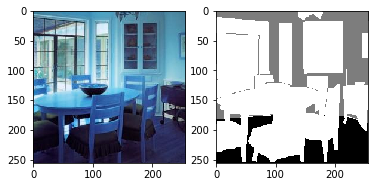

In [13]:
print(train_imgs[0].shape)

mask = np.reshape(train_masks[0],(256,256,3))
print(mask.shape)

plt.subplot(121)
plt.imshow(train_imgs[0])

plt.subplot(122)
plt.imshow(mask)

In [14]:
def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    
    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
    X = Convolution2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Convolution2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Convolution2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Convolution2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    base = conv_block(input_layer,[32,32,64],'1')
    # block_2
    base = conv_block(base,[64,64,128],'2')
    # block_3
    base = conv_block(base,[128,128,256],'3')
    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tf.keras.layers.Reshape((1,1,256))(red)
    red = Convolution2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=256,interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Convolution2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Convolution2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Convolution2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Convolution2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    X = Activation('sigmoid',name='last_conv_relu')(X)
    X = tf.keras.layers.Flatten(name='last_conv_flatten')(X)
    return X

In [15]:
input_layer = tf.keras.Input(shape=np.squeeze(train_imgs[0]).shape,name='input')
output_layer = last_conv_module(input_layer)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block_1_a (Conv2D)              (None, 256, 256, 32) 128         input[0][0]                      
__________________________________________________________________________________________________
block_1_batch_norm_a (BatchNorm (None, 256, 256, 32) 128         block_1_a[0][0]                  
__________________________________________________________________________________________________
block_1_leakyrelu_a (LeakyReLU) (None, 256, 256, 32) 0           block_1_batch_norm_a[0][0]       
______________________________________________________________________________________________

In [28]:
#model.load_weights('/kaggle/input/best-modelh5/best_model.h5')

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
model.fit(np.array(train_imgs,dtype='float16'), np.array(train_masks,dtype='float16'),
          validation_data=(np.array(valid_imgs, dtype='float16'), np.array(valid_masks, dtype='float16')),
          epochs=100, steps_per_epoch=100, verbose=1, batch_size=3)

Train on 589 samples, validate on 28 samples
Epoch 1/100
298/589 [==============>...............] - ETA: 13s - loss: 0.1084 - val_loss: 0.1086Epoch 84/100


300/589 [==============>...............] - ETA: 13s - loss: 0.1047 - val_loss: 0.0992

In [61]:
model.save("/media/kimbring2/Steam/sim2real/segmentation_model/weight")

INFO:tensorflow:Assets written to: /media/kimbring2/Steam/sim2real/segmentation_model/weight/assets


In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 5
epochs = 100
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = len(train_imgs) * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

model_for_pruning.summary()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

model_for_pruning.fit(np.array(train_imgs,dtype='float16'), np.array(train_masks,dtype='float16'),
                      validation_data=(np.array(valid_imgs, dtype='float16'), np.array(valid_masks, dtype='float16')),
                      epochs=100, steps_per_epoch=100, verbose=1, batch_size=5, callbacks=callbacks)

In [20]:
model_for_pruning.save("/media/kimbring2/Steam/sim2real/segmentation_model/weight")
#model_for_pruning.load_weights("/media/kimbring2/Steam/sim2real/segmentation_model/weight/variables/variables")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /media/kimbring2/Steam/sim2real/segmentation_model/weight/assets


In [18]:
def plot_imgs(img,mask,pred):
    mask = np.reshape(mask,(32,32,3))
    pred = np.reshape(pred,(32,32,3))
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,10))
    ax1.imshow(img)
    ax1.axis('off')
    ax2.imshow(mask)
    ax2.axis('off')
    ax3.imshow(pred)
    ax3.axis('off')

In [56]:
valid_imgs[0].shape

(32, 32, 3)

In [62]:
tf.__version__

'2.1.0'

pred_masks.shape:(1, 3072)


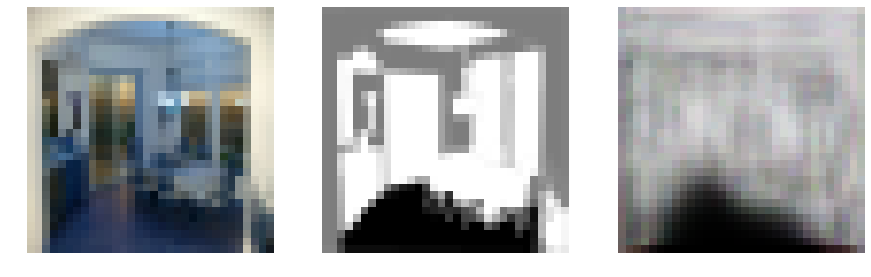

In [57]:
index = 3

valid_imgs_input = np.reshape(valid_imgs[index],(1,32,32,3))
valid_masks_input = np.reshape(valid_masks[index],(1,32,32,3))

#print("pred_masks.shape:" + str(pred_masks.shape))

pred_masks = model.predict(valid_imgs_input)
#pred_masks = np.reshape(pred_masks,(1,256,256,3))
print("pred_masks.shape:" + str(pred_masks.shape))


#print('-------------Input---------------Actual mask--------------Predicted mask-------')
#for i in range(5):
#x = np.random.randint(0,5,size=1)[0]
plot_imgs(valid_imgs[index],valid_masks[index],pred_masks)

In [ ]:
'''
model.fit(np.array(train_imgs,dtype='float16'), np.array(train_masks,dtype='float16'),
          validation_data=(np.array(valid_imgs, dtype='float16'), np.array(valid_masks, dtype='float16')),
          epochs=100, steps_per_epoch=100, verbose=1, batch_size=5)
'''

pred_masks.shape: (256, 256, 3)


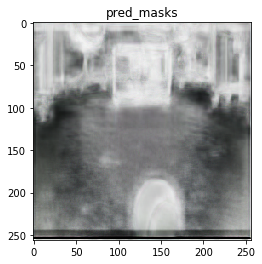

In [32]:
import cv2

#image_path = '/media/kimbring2/Steam/sim2real/images/tennis_ball_image/71HxOsmPUHL._AC_SL1201_.jpg'
#image_path = '/media/kimbring2/Steam/sim2real/images/deepsoccer_content.jpg'
image_path = '/home/kimbring2/Desktop/content_image/image_15.jpg'
test_image = cv2.imread(image_path)
test_image_copy = test_image
test_image = cv2.normalize(test_image, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
#test_image = (test_image / 127.5) - 1

test_tensor = tf.convert_to_tensor(test_image, dtype=tf.float32)

test_tensor = tf.image.resize(test_tensor, [256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
test_tensor = tf.reshape(test_tensor, [1,256,256,3], name=None)

pred_masks = model.predict(test_tensor)
pred_masks = np.reshape(pred_masks,(256,256,3))

print("pred_masks.shape: " + str(pred_masks.shape))

plt.title('pred_masks')
plt.imshow(pred_masks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256)
(256, 256, 3)


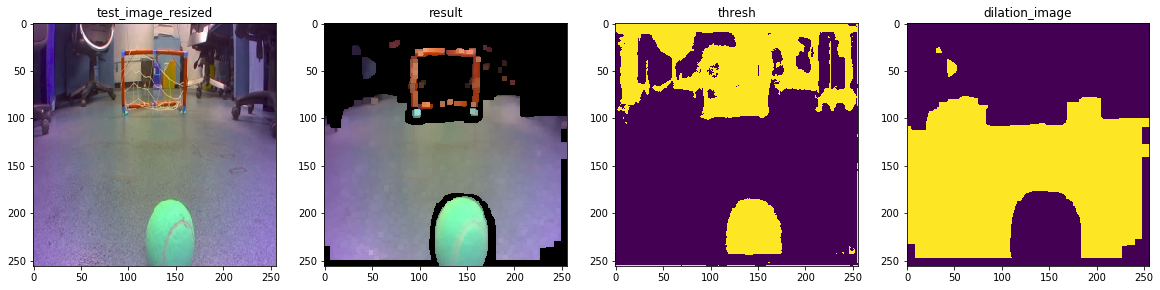

In [83]:
test_image_resized = cv2.resize(test_image, dsize=(256,256), interpolation=cv2.INTER_AREA)
test_image_copy = cv2.resize(test_image_copy, dsize=(256,256), interpolation=cv2.INTER_AREA)

frame = test_image_copy

pred_masks = model.predict(test_tensor)
pred_masks = np.reshape(pred_masks,(256,256,3))
pred_masks = pred_masks * 255
pred_masks = cv2.cvtColor(pred_masks, cv2.COLOR_RGB2GRAY) 

ret, thresh = cv2.threshold(pred_masks, 180, 255, cv2.THRESH_BINARY)

kernel = np.ones((15, 15), np.uint8)
dilation_image = cv2.dilate(thresh, kernel, iterations=1)  #// make dilation image
dilation_image = dilation_image != 255.0
print(dilation_image.shape)
#dilation_image = cv2.cvtColor(np.float32(dilation_image), cv2.COLOR_GRAY2RGB) 

# converting from BGR to HSV color space
hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# Blue color
low_blue = np.array([110, 130, 2])
high_blue = np.array([126, 255, 255])
blue_mask = cv2.inRange(hsv_frame, low_blue, high_blue)
blue = cv2.bitwise_and(frame, frame, mask=blue_mask)
#blue = cv2.cvtColor(blue, cv2.COLOR_BGR2GRAY)

# Green color
low_green = np.array([25, 52, 72])
high_green = np.array([60, 255, 255])
green_mask = cv2.inRange(hsv_frame, low_green, high_green)
green = cv2.bitwise_and(frame, frame, mask=green_mask)

mask = blue_mask + green_mask + dilation_image

# Every color except white
low = np.array([0, 42, 0])
high = np.array([179, 255, 255])
result = cv2.bitwise_and(frame, frame, mask=mask)
kernel = np.ones((5, 5), np.uint8)
result = cv2.dilate(result, kernel, iterations=1)  #// make dilation image
print(result.shape)

#dilation_image = dilation_image != 255
#print(dilation_image.shape)
#print(dilation_image[128,0])

#b = dilation_image != 255.0
#erosion_image = cv2.erode(dilation_image, kernel, iterations=1)  #// make erosion image

fig, ax = plt.subplots(1, 4, figsize=(20,80))

ax[0].set_title('test_image_resized')
ax[0].imshow(test_image_resized)

ax[1].set_title('result')
ax[1].imshow(result)

ax[2].set_title('thresh')
ax[2].imshow(thresh)

ax[3].set_title('dilation_image')
ax[3].imshow(dilation_image)

In [1]:
#import cv2
import numpy as np
import tensorflow as tf

# gstreamer_pipeline returns a GStreamer pipeline for capturing from the CSI camera
# Defaults to 1280x720 @ 60fps
# Flip the image by setting the flip_method (most common values: 0 and 2)
# display_width and display_height determine the size of the window on the screen

imported_seg = tf.saved_model.load("/home/kimbring2/Desktop/segmentation_model/weight/")
#print("last")

f_seg = imported_seg.signatures["serving_default"]
seg_test_input = np.zeros([1,32,32,3])
seg_test_tensor = tf.convert_to_tensor(seg_test_input, dtype=tf.float32)
print(f_seg(seg_test_tensor))
print("last")

{'last_conv_flatten': <tf.Tensor: shape=(1, 3072), dtype=float32, numpy=
array([[0.60637164, 0.61511767, 0.6758111 , ..., 0.09449747, 0.05955463,
        0.07836635]], dtype=float32)>}
last
